## Exploratory Data Analysis - Precipitation

In this section we will perform a detailed EDA for the Caribbean Region precipitation dataset for the 1980 - 2025 period. The original dataset is fetched from the [NOAA website](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/service-api).

In particular, we will focus on the following analysis:

- Detecting trends
- Examining variability
- Defining and analysing extremes i.e. hurricanes and heavy rains
- Rolling statistics
- Precipitation Heatmap

**Author:** Nazgul Sagatova  
**Last updated:** 2025-12-4 

Previous notebooks:

[[01-download-and-data-wrangling.ipynb](01-download-and-data-wrangling.ipynb)

[02-descriptive-stats.ipynb](02-descriptive-stats.ipynb)

[03-EDA-temperature-anomaly.ipynb](03-EDA-temperature-anomaly.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

In [9]:
df.head()

,temp_anomaly,precip,year,month,temp_3m,temp_6m,temp_12m,temp_10y,temp_rolling_std,season
date,,,,,,,,,,
1980-01-01,0.29,44.59,1980,1,NaN,NaN,NaN,NaN,NaN,DJF
1980-02-01,0.31,79.07,1980,2,0.293333,NaN,NaN,NaN,NaN,DJF
1980-03-01,0.28,99.58,1980,3,0.293333,NaN,NaN,NaN,NaN,MAM
1980-04-01,0.29,155.65,1980,4,0.306667,0.316667,NaN,NaN,NaN,MAM
1980-05-01,0.35,256.91,1980,5,0.340000,0.336667,NaN,NaN,NaN,MAM


## Create additional Time Aggregations

In [8]:
df['season'] = df.index.month.map({12: 'DJF', 1: 'DJF', 2: 'DJF',
                                        3: 'MAM', 4: 'MAM', 5: 'MAM',
                                        6: 'JJA', 7: 'JJA', 8: 'JJA',
                                        9: 'SON', 10:'SON', 11:'SON'})

# Precipitation

## Recall the Caribbean Region precipitation distribution

As we remember it is right-skewed. In weather data, this means that there is a greater concentration of values around the mean and higher likelihood of extreme, rare events. These stats are describing heavy rains during hurricanes and tropical storms.

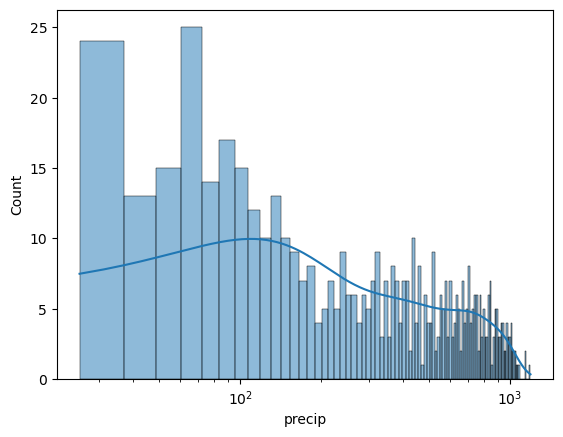

In [11]:
# Highly right-skewed → use log or sqrt for visualization
df['precip'].describe()
sns.histplot(df['precip'], bins=100, kde=True)
plt.xscale('log')  # or plt.xlim(0,50)

## Detecting Trends

We will start by plotting our time series **Precipitation** data grouped:
- by month to detect seasonality
- by year to detect long term changes

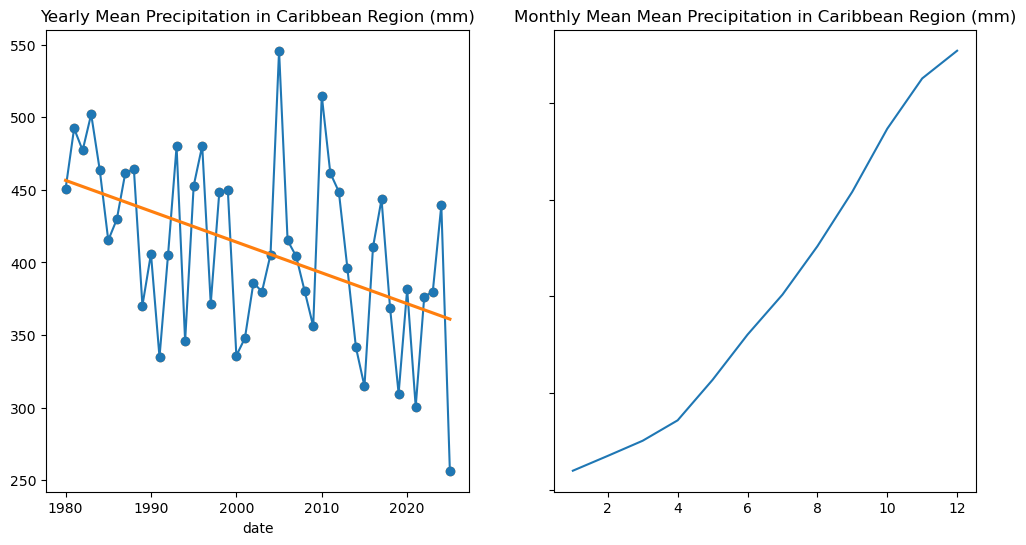

In [22]:
yearly_mean = df.groupby(df.index.year)[['temp_anomaly', 'precip']].mean()
monthly_mean = df.groupby(df.index.month)[['temp_anomaly', 'precip']].mean()

fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(12,6))

ax1.plot(yearly_mean['precip'], marker='o')
ax1.set_title("Yearly Mean Precipitation in Caribbean Region (mm)")
# Add linear trend line
sns.regplot(x=yearly_mean.index, y=yearly_mean['precip'].values, ci=None, ax = ax1)

ax2.plot(monthly_mean['precip'])
ax2.set_title("Monthly Mean Mean Precipitation in Caribbean Region (mm)")

for ax in fig.get_axes():
    ax.label_outer()


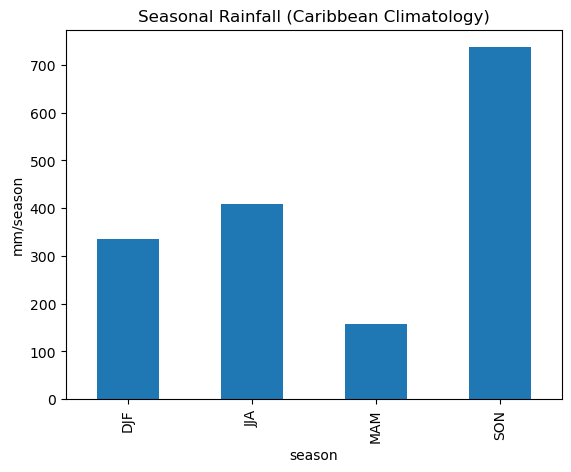

In [15]:
# Wet season (May–Nov) vs Dry season (Dec–Apr)
seasonal = df.groupby('season')['precip'].mean()
seasonal.plot(kind='bar')
plt.title('Seasonal Rainfall (Caribbean Climatology)')
plt.ylabel('mm/season')
plt.show()



### Wettest Years in Caribbean Region

The wettest 5 years of the Caribbean : date
1981    492.300833
1983    502.058333
1996    480.343333
2005    545.836667
2010    514.887500
Name: precip, dtype: float64
The wettest 5 months of the Caribbean : date
8     503.476739
9     616.150000
10    746.193043
11    850.039778
12    907.256889
Name: precip, dtype: float64


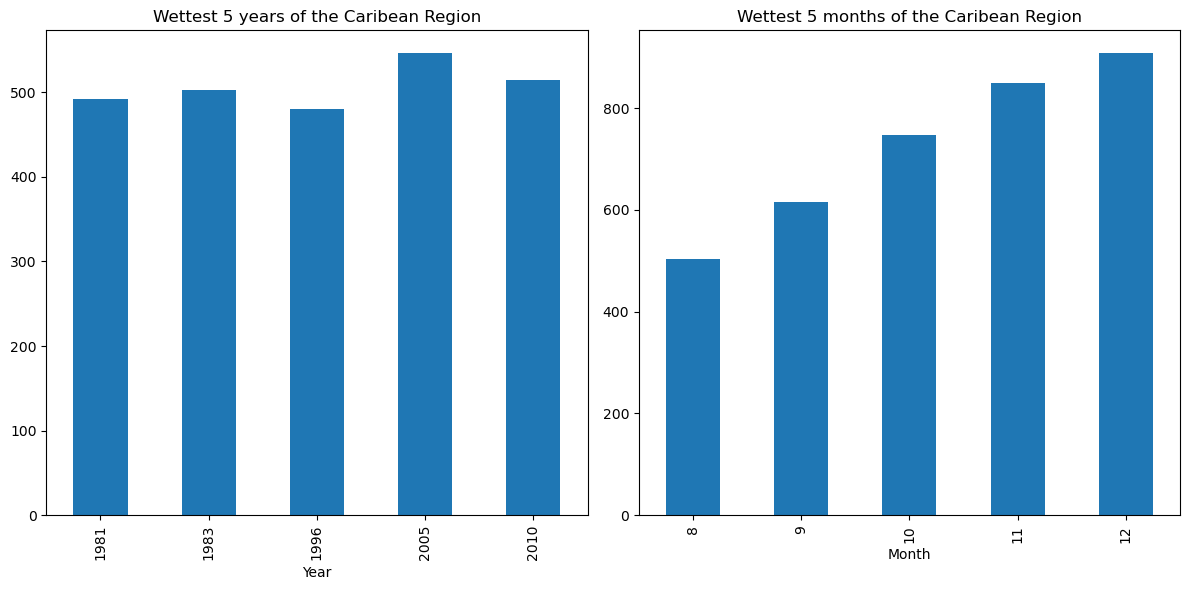

In [5]:
n = 5
peak_precip_y = yearly_mean['precip'].nlargest(n).sort_index()
peak_precip_m = monthly_mean['precip'].nlargest(n).sort_index()

print(f'The wettest {n} years of the Caribbean : {peak_precip_y}')
print(f'The wettest {n} months of the Caribbean : {peak_precip_m}')

f, (ax1, ax2) = plt.subplots(1,2,sharex=False, figsize=(12,6))

peak_precip_y.plot(kind='bar', title=f'Wettest {n} years of the Caribean Region', ax=ax1)
ax1.set_xlabel('Year')

peak_precip_m.plot(kind='bar', title=f'Wettest {n} months of the Caribean Region', ax=ax2)
ax2.set_xlabel('Month')

plt.tight_layout()
plt.show()



### Rainy Months and Intensity Metrics (per decade)

A month is considered rainy if the precipitation exceeds **100mm** for that month according to World Meteorological Organization (WMO) and NOAA National Centers for Environmental Information (NCEI) Caribbean reports.

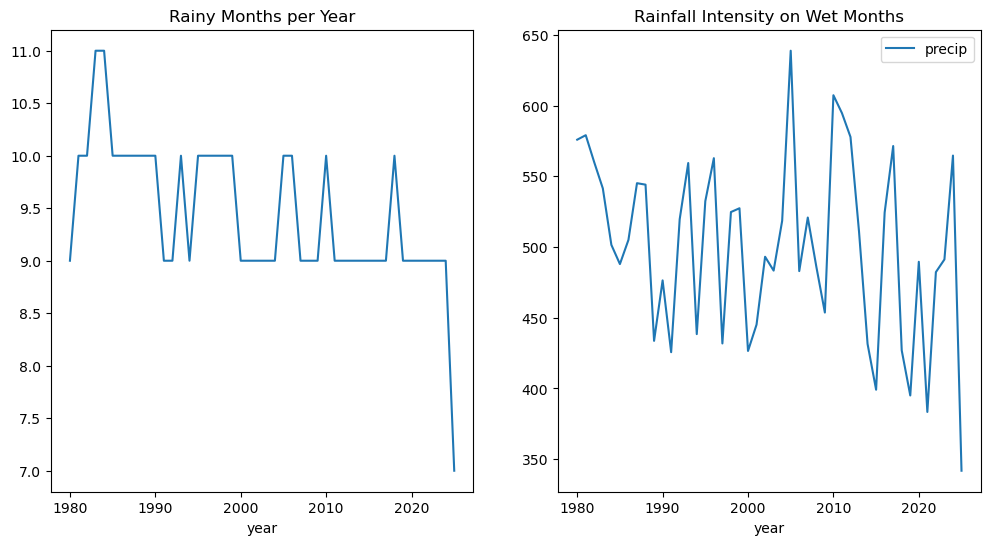

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=False)

df['rainy_month'] = df['precip'] > 100.0  # standard threshold for caribbean

# Number of rainy months per year
df.groupby('year')['rainy_month'].sum().plot(title='Rainy Months per Year', ax = ax1)

# Average intensity on rainy days
(df[df['precip']>100.0].groupby('year')['precip'].mean()).plot(title='Rainfall Intensity on Wet Months', ax = ax2)

#plt.yscale('log')

### Rainfall decrease rate

In [38]:
df['decade'] = (df['year'] // 10) * 10 #establishing a decade column for analysis

# Calculate the average rainfall decrease per decade using scipy.linregress
slope, intercept, r_value, p_value, std_err = linregress(df['decade'], df['precip'])

print(f"Rainfall decreased by {slope:.4f} mm per decade")
print(f"Total decrease over period: {slope * (df['year'].max() - df['year'].min()):.2f} mm")

Rainfall decreased by -1.9865 mm per decade
Total decrease over period: -89.39 mm


### Rainfall percentage decrease per decade

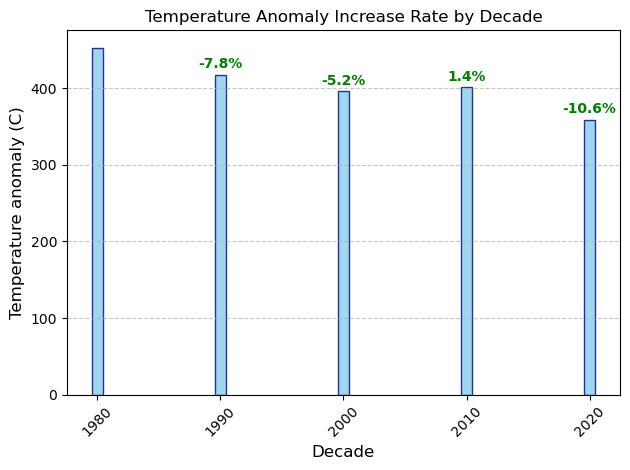

In [45]:
decade = df.groupby('decade')['precip'].mean()
decade.sort_values(ascending=True)

# calculate percentage decrease for each decade compared to the previous decade
decrease_rates = ['']  # First bar has no previous value
values = decade.values
for i in range(1, len(values)):
    decrease = values[i] - values[i-1]
    rate = (decrease / values[i-1]) * 100
    decrease_rates.append(f'{rate:.1f}%')


bars = plt.bar(decade.index, decade.values, width=0.85, color='skyblue', edgecolor='navy', alpha=0.8)
# Add the increase rate text on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    if i > 0:  # Skip the first bar or show value only
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(values) * 0.01),decrease_rates[i],
                 ha='center', va='bottom', fontweight='bold', color='green', fontsize=10)


plt.title('Temperature Anomaly Increase Rate by Decade')
plt.ylabel('Temperature anomaly (C)', fontsize=12)
plt.xlabel('Decade', fontsize=12)
plt.xticks(np.arange(1980, 2030, step=10),rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

### Monthly Trends

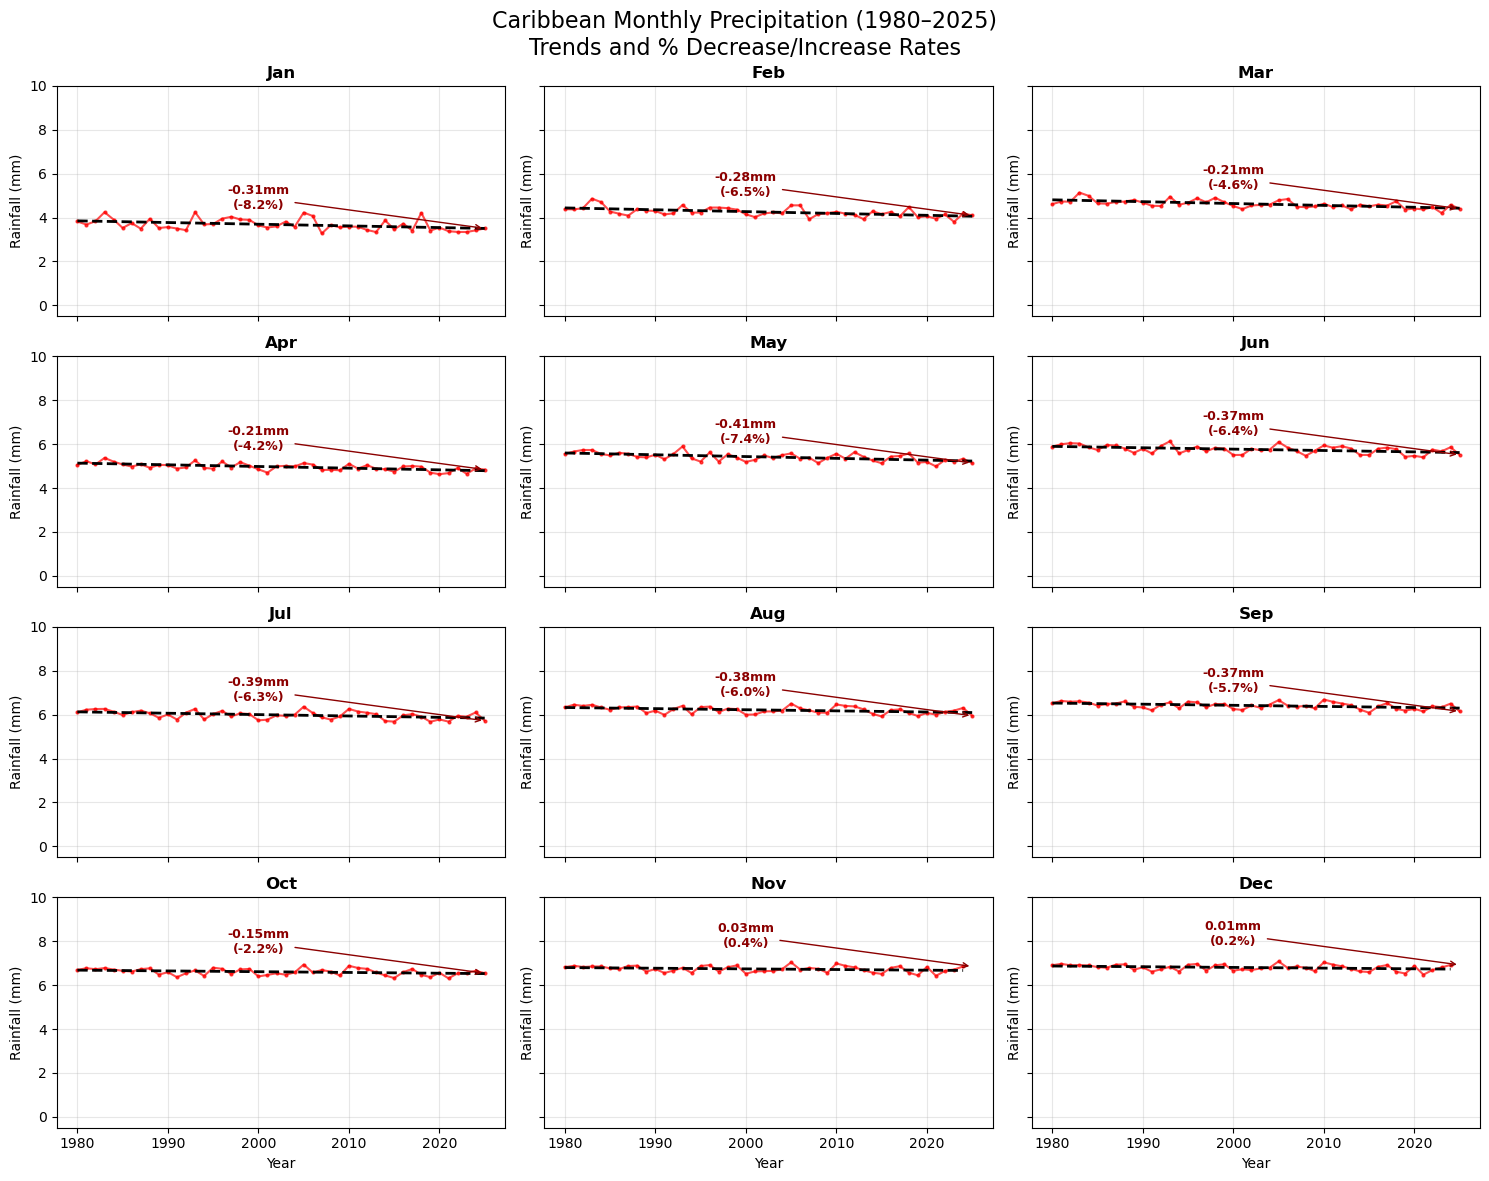


SUMMARY OF MAIN TRENDS
- Overall annual avg. precipitation decrease: - 256.49mm (from 450.54mm)
- Overall % decrease: - -43.1% over 45 years


In [69]:
import calendar
from scipy import stats

# Step 2: Create mini plots (one subplot per month)
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

month_names = [calendar.month_abbr[i] for i in range(1, 13)]

for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    
    # Filter data for this month
    month_df = df[df['month'] == month]
    y = month_df['year'].values
    anomalies = month_df['precip'].values
    anomalies_log = np.log1p(anomalies)
    
    # Plot the line (mini plot)
    ax.plot(y, anomalies_log, color='red', linewidth=1.5, alpha=0.7, marker='o', markersize=2)
    
    # Fit linear trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(y, anomalies_log)
    trend_line = slope * y + intercept
    ax.plot(y, trend_line, color='black', linewidth=2, linestyle='--', label=f'Trend (R²={r_value**2:.2f})')
    
    # Calculate total change and percentage increase (relative to 1980 baseline)
    start_anom = anomalies_log[0]
    end_anom = anomalies_log[-1]
    total_change = end_anom - start_anom
    pct_increase = (total_change / abs(start_anom) if start_anom != 0 else 0) * 100  # Avoid div by zero
    
   
    # Add labels
    ax.set_title(f'{month_names[month - 1]}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rainfall (mm)', fontsize=10)
    if i >= 9:  # Bottom row for x-labels
        ax.set_xlabel('Year', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.5, 10.0)  # Consistent y-limits for comparison
    
    # Annotate percentage increase on the trend line (near end)
    ax.annotate(f'{total_change:.2f}mm\n({pct_increase:.1f}%)', 
                xy=(2025, end_anom), xytext=(2000, end_anom + 0.9),
                arrowprops=dict(arrowstyle='->', color='darkred'), 
                ha='center', fontsize=9, color='darkred', fontweight='bold')

plt.suptitle('Caribbean Monthly Precipitation (1980–2025)\nTrends and % Decrease/Increase Rates', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Step 3: Compute and print summary statistics
print("\n" + "="*60)
print("SUMMARY OF MAIN TRENDS")
print("="*60)

# Overall trend across all months
all_anoms_1980 = df[df['year'] == 1980]['precip'].mean()
all_anoms_2025 = df[df['year'] == 2025]['precip'].mean()
overall_pct = ((all_anoms_2025 - all_anoms_1980) / abs(all_anoms_1980)) * 100
print(f"- Overall annual avg. precipitation decrease: - {all_anoms_2025:.2f}mm (from {all_anoms_1980:.2f}mm)")
print(f"- Overall % decrease: - {overall_pct:.1f}% over 45 years")

## Exploring Variability

In EDA, explaining variability is as important as explaining trend. For climate data, this is especially true as extremes and variability drive the way climate impacts human health, infrastructure, agriculture, ecosystems.

In this section, we will be exploring the following variability statistics:

### Standard Deviation, IQR and Coefficient of Variation

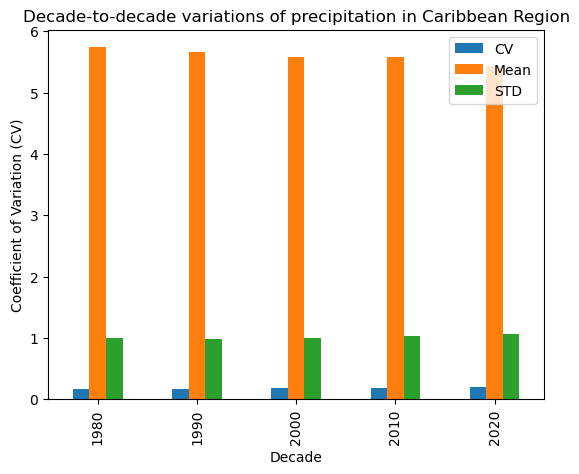

In [71]:
#Plotting CV rates based on decades

df['precip_log'] = np.log1p(df['precip'])

stddec = df.groupby('decade')['precip_log'].std()
meandec = df.groupby('decade')['precip_log'].mean().abs()

cvdec = (stddec / meandec)

ddf = pd.DataFrame({
    'CV' : cvdec,
    'Mean' : meandec,
    'STD' : stddec
})

ddf.plot(kind = 'bar', title = 'Decade-to-decade variations of precipitation in Caribbean Region')
plt.xlabel('Decade')
plt.ylabel('Coefficient of Variation (CV)')
plt.show()


### Heavy Rainfall/Dryness: defining extremes using 5th/95th/99th percentiles

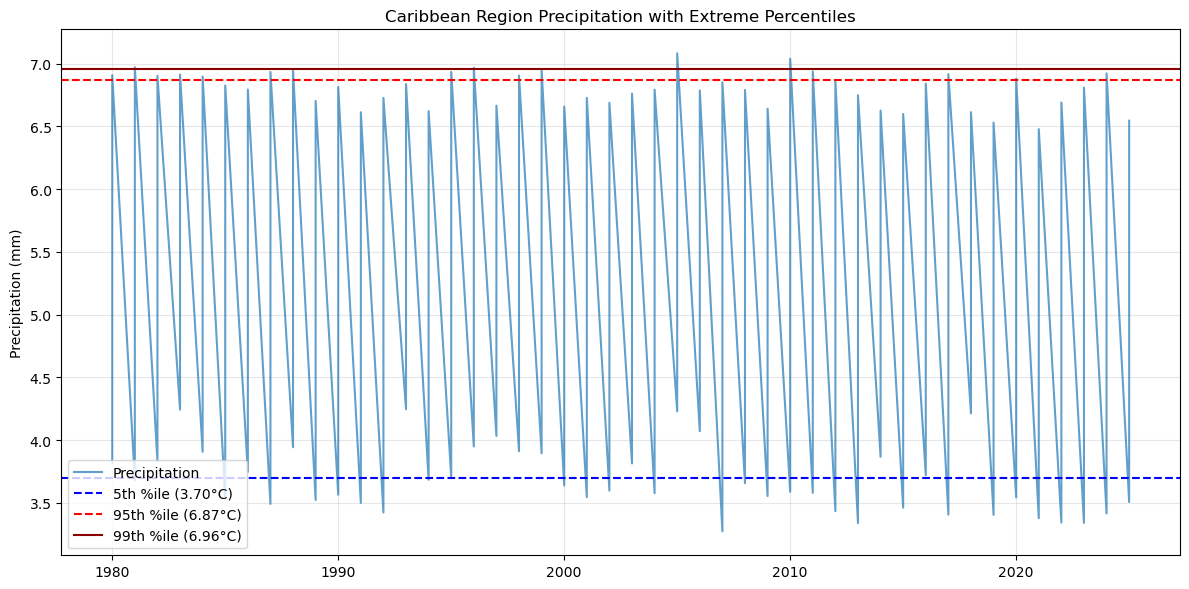

In [72]:

# Compute global percentiles
p5_anom  = df['precip_log'].quantile(0.05)
p95_anom = df['precip_log'].quantile(0.95)
p99_anom = df['precip_log'].quantile(0.99)

# Plot
fig = plt.figure(figsize = (12, 6))

# Precipitation
plt.plot(df['year'], df['precip_log'], label='Precipitation', color='tab:blue', alpha=0.7)
plt.axhline(p5_anom,  color='blue', linestyle='--', label=f'5th %ile ({p5_anom:.2f}°C)')
plt.axhline(p95_anom, color='red',  linestyle='--', label=f'95th %ile ({p95_anom:.2f}°C)')
plt.axhline(p99_anom, color='darkred', linestyle='-', label=f'99th %ile ({p99_anom:.2f}°C)')
plt.ylabel('Precipitation (mm)')
plt.title('Caribbean Region Precipitation with Extreme Percentiles')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [80]:
#Count the number of extreme precipitation

p5_sum = (df['precip_log'] < p5_anom).sum()
p95_sum = (df['precip_log'] > p95_anom).sum()
p99_sum = (df['precip_log'] > p99_anom).sum()
print('Caribbean Region Precipitation Extremes (in months)')
print(f'Number of very dry months = {p5_sum:.2f}')
print(f'Number of moderately extreme wet months = {p95_sum:.2f}')
print(f'Number of very extreme wet months = {p99_sum:.2f}')

Caribbean Region Precipitation Extremes (in months)
Number of very dry months = 28.00
Number of moderately extreme wet months = 28.00
Number of very extreme wet months = 6.00


### Rolling Statistics: to smooth noise and highlight trends

In [81]:
#Precipitation
df['rain_3m'] = df['precip'].rolling(window=3, center=True).mean()
df['rain_6m'] = df['precip'].rolling(window=6, center=True).mean()
df['rain_12m'] = df['precip'].rolling(window=12, center=True).mean()
df['rain_10y'] = df['precip'].rolling(window=120, center=True).mean()
df['rain_rolling_std'] = df['precip'].rolling(window=120).std()  # 10-year variability

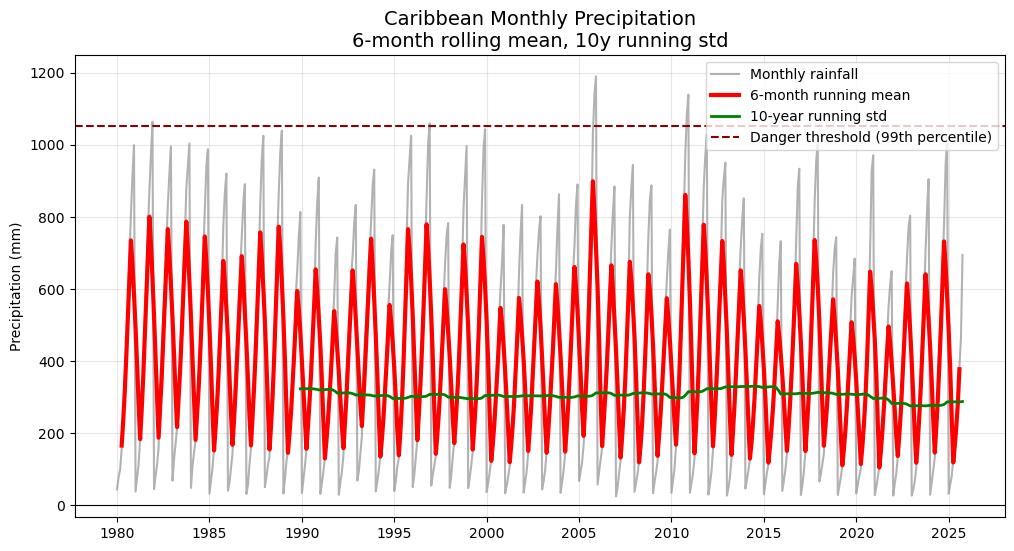

In [87]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['precip'], color='gray', alpha=0.6, label='Monthly rainfall')
plt.plot(df.index, df['rain_6m'],  color='red',   linewidth=3, label='6-month running mean')
plt.plot(df.index, df['rain_rolling_std'], color='green', linewidth=2, label = '10-year running std')
plt.axhline(0, color='black', linewidth=0.8)
plt.axhline(1052, color='darkred', linestyle='--', label='Danger threshold (99th percentile)')
plt.title('Caribbean Monthly Precipitation\n6-month rolling mean, 10y running std', fontsize=14)
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Monthly Precipitation Heatmap

We can observe heavy precipitation in 2005, 2010, 2017, 2020.

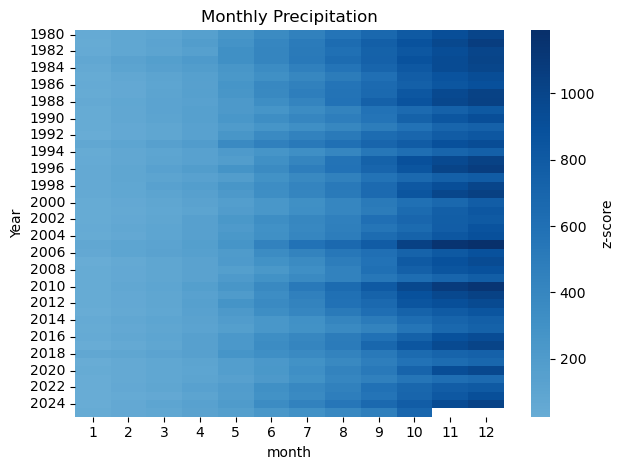

In [88]:
# Reshape to Year x Month
pcp_pivot = df.pivot_table(values='precip', index='year', columns='month', aggfunc='mean')

fig = plt.Figure(figsize=(14, 10))

sns.heatmap(pcp_pivot, cmap='Blues', center=0, cbar_kws={'label': 'z-score'})
plt.title('Monthly Precipitation')
plt.ylabel('Year')

plt.tight_layout()
plt.show()

## Violin Plots - Final Analysis

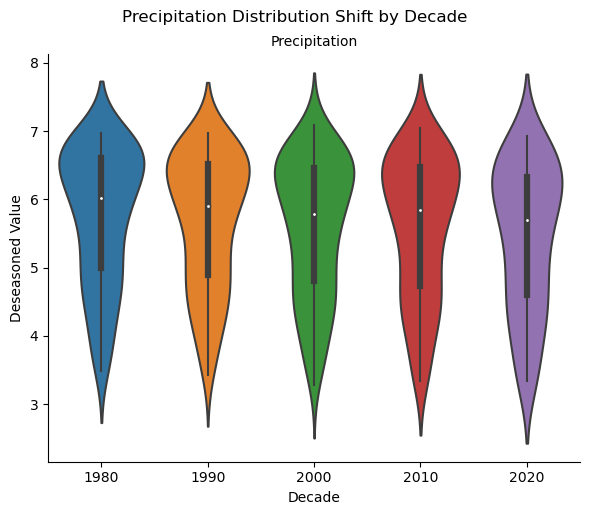

In [92]:
g = sns.catplot(
    data=df.melt(id_vars='decade', value_vars=['precip_log'],
                 var_name='Variable', value_name='Value'),
    x='decade', y='Value', col='Variable', kind='violin',
    height=5, aspect=1.2, sharey=False
)
g.set_titles("Precipitation")
g.set_axis_labels("Decade", "Deseasoned Value")
plt.suptitle('Precipitation Distribution Shift by Decade', y=1.02)
plt.show()

In [93]:
df.head()

,temp_anomaly,precip,year,month,temp_3m,temp_6m,temp_12m,temp_10y,temp_rolling_std,season,rainy_month,decade,precip_log,rain_3m,rain_6m,rain_12m,rain_10y,rain_rolling_std
date,,,,,,,,,,,,,,,,,,
1980-01-01,0.29,44.59,1980,1,NaN,NaN,NaN,NaN,NaN,DJF,False,1980,3.819688,NaN,NaN,NaN,NaN,NaN
1980-02-01,0.31,79.07,1980,2,0.293333,NaN,NaN,NaN,NaN,DJF,False,1980,4.382901,74.413333,NaN,NaN,NaN,NaN
1980-03-01,0.28,99.58,1980,3,0.293333,NaN,NaN,NaN,NaN,MAM,False,1980,4.610953,111.433333,NaN,NaN,NaN,NaN
1980-04-01,0.29,155.65,1980,4,0.306667,0.316667,NaN,NaN,NaN,MAM,True,1980,5.054014,170.713333,165.970,NaN,NaN,NaN
1980-05-01,0.35,256.91,1980,5,0.340000,0.336667,NaN,NaN,NaN,MAM,True,1980,5.552611,257.526667,233.305,NaN,NaN,NaN


In [90]:
# Final save — everyone will read this file
df.to_parquet("../data/processed/caribbean_temp_precip_1980_2025.parquet", index=True)
print("Processed dataset saved → ready for EDA notebooks")

Processed dataset saved → ready for EDA notebooks


# Caribbean Precipitation EDA Insights

## Detecting Trends

#### Annual Precipitation Trends
- The overall trend seems to be going down since 1980 we can also see sudden spikes accross years. 
- Recent years starting from 2024, show significant dryness, indicated by the sudden drop at the end of the plot.
- Years 1981, 1983, 1996, 2005 and 2010 have had the heaviest rainfall in recorded history.

#### Monthly Precipitation Trends
- End of the year looks much wetter than the beginning of the year, with December being the wettest month, possible due to hurricane season. 
- The wettest season, logically, is September - October - November due to hurricane season.
- Overall annual avg. precipitation decrease: - 256.49mm (from 450.54mm)
- Overall % decrease: - -43.1% over 45 years

#### Rainy Months and Intensity
- The number of wet months is decreasing (back in 1980s, it rained almost whole year)
- The intensity of rainfall is increasing, meaning that rains are becoming heavier -> 'fewer but heavier events'.

#### Rainfall decrease rate
- Rainfall decreased by -1.9865 mm per decade. Total decrease over period: -89.39 mm
- Every decade, rainfall decreased, with 10% decrease in decade 2020.

### Exploring Variability

#### Standard Deviation, IQR and Coefficient of Variation
- Rainfall variability was stable across decades as seen in the plot. 

#### Heavy Rainfall/Dryness: defining extremes using 5th/95th/99th percentiles
- Caribbean Region Precipitation Extremes (in months)
- Number of very dry months = 28.00
- Number of moderately extreme wet months = 28.00
- Number of very extreme wet months = 6.00

### Rolling Statistics
- The **12-month moving average** shows no consistent trend but strong seasonal cycles, while the **moving standard deviation** highlights elevated variability during wet seasons, with occasional spikes linked to extreme events.

### Precipitation HeatMap
- Heavy precipitation in 2005, 2010, 2017, 2020.

## Violin Plot by Decade: Shift in Distributions

The violin plot answers the two most important climate questions:

- Has the climate shifted? (location of the distribution)
- Has the climate become more extreme or more variable? (shape and tails of the distribution)


For precipitation, the median remains near zero (no change in typical wetness), but the 95th percentile rises dramatically (+50–100% in IQR units), confirming intensification of heavy rain.
The lower tail (dry extremes) also extends further in recent decades, indicating more severe droughts despite stable median precipitation.
This "mean shift + tail fattening" pattern is the fingerprint of anthropogenic forcing: thermodynamics (Clausius-Clapeyron) drives wet extremes, dynamics drive dry extremes.

For precipitation, the climate has become more extreme without becoming wetter on average — the violins stay centered on zero but develop longer, fatter tails in both directions, exactly the pattern expected under anthropogenic forcing.

By the 2020s, a month that would have been considered a 1-in-50-year extreme in the 1960s is now approaching the new normal for heavy precipitation.